<a href="https://colab.research.google.com/github/kyochanpy/forest_bears/blob/main/nb_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!pip install jismesh
!pip install folium

     |████████████████████████████████| 1.0 MB 3.8 MB/s 
     |████████████████████████████████| 15.4 MB 22.8 MB/s 
     |████████████████████████████████| 6.3 MB 44.9 MB/s 


In [ ]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


import geopandas as gpd

import jismesh.utils as ju
import folium
from shapely.geometry import Polygon
import branca.colormap as cm


In [ ]:
all_df = pd.read_csv("/content/drive/MyDrive/forest_bears/all_df.csv")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/forest_bears/forest_bears_with_latlng.csv')

In [ ]:
def get_date_time_features(input_df):
    input_df_ = input_df.copy()

    no_values = input_df_["No."].values
    len_list_ = []
    for i in range(len(no_values)+1):
        if no_values[i+1] - no_values[i] != 1:
            len_list_.append(i)
            if len(len_list_) == 4:
                break
    len_list_.append(len(no_values))
    
    len_list = []
    for i in range(0,len(len_list_)):
        i_ = len_list_[i] - len_list_[i-1]
        len_list.append(i_)
    len_list[0] = len_list_[0]

    fiscal_year_list = []
    for i, j in zip(
        len_list,
        ["28", "29", "30", "1", "2"]
    ):
        fiscal_year_list = fiscal_year_list + [j] * i
    
    year_list = []
    month_list = []
    day_list = []
    day_week_list = []
    time_list = []
    for i in input_df_["発生日時"].values:
        i = i.replace(" ", "")
        if len(i) > 14:
            i_list = re.findall(r"\d+", i)
            if i_list[0] == "28":
                year_list.append(f"{i_list[0]}")
            else:
                year_list.append(f"{i_list[0]}")
            month_list.append(i_list[1])
            day_list.append(i_list[2])
            day_week_list.append(i[-7])
            time_list.append(i[-5:])
        elif len(i) <= 10:
            i_list = re.findall(r"\d+", i)
            year_list.append("不明")
            month_list.append(i_list[0])
            day_list.append(i_list[1])
            day_week_list.append(i[-2])
            time_list.append("不明")
        elif (len(i) > 10) and (i[-3] == ":"):
            i_list = re.findall(r"\d+", i)
            year_list.append("不明")
            month_list.append(i_list[0])
            day_list.append(i_list[1])
            day_week_list.append(i[-7])
            time_list.append(i[-5:])
        else:
            i_list = re.findall(r"\d+", i)
            if i_list[0] == "28":
                year_list.append(f"{i_list[0]}")
            else:
                year_list.append(f"{i_list[0]}")
            month_list.append(i_list[1])
            day_list.append(i_list[2])
            day_week_list.append(i[-2])
            time_list.append("不明")

    output_df = pd.DataFrame()
    output_df["年度"] = fiscal_year_list
    output_df["年"] = year_list
    output_df["月"] = month_list
    output_df["日"] = day_list
    output_df["曜日"] = day_week_list
    output_df["時間"] = time_list
   
    fixed_year_list = []
    for f, y, m in zip(
        output_df["年度"].values,
        output_df["年"].values,
        output_df["月"].values
    ):
        if y != "不明":
            fixed_year_list.append(y)
        else:
            if 4 <= int(m) <= 12:
                fixed_year_list.append(f)
            else:
                if y == "r2":
                    fixed_year_list.append("r3")
                else:
                    fixed_year_list.append(fixed_year_list[fixed_year_list.index(y)+1])
    output_df["年"] = fixed_year_list  

    output_df["年度"] =  output_df["年度"].astype(int)
    output_df["年"] = output_df["年"].astype(int)
    output_df["月"] = output_df["月"].astype(int)
    output_df["日"] = output_df["日"].astype(int)

    return output_df

In [ ]:
def get_geometry_features(input_df, path):
    input_df_ = input_df.copy()
    geo_df = gpd.read_file(path)

    geo_df["KEY_CODE"] = geo_df["KEY_CODE"].astype(int)

    output_df = pd.merge(input_df_, geo_df.iloc[:, [0,-1]], on="KEY_CODE")

    return output_df

In [ ]:
def get_mesh4_features(input_df):
    input_df_ = input_df.copy()

    mesh4_list = []
    for lat, lng in zip(
        input_df_["lat"].to_numpy(),
        input_df_["lng"].to_numpy()
    ):
        mesh_code = ju.to_meshcode(lat, lng, 4)
        mesh4_list.append(mesh_code)
    
    output_df = input_df.copy()
    output_df["KEY_CODE"] = mesh4_list

    return output_df

In [ ]:
def get_population_mesh4_features(path):
    df = pd.read_table(path, sep='\s+|,', engine='python')

    output_df = df.loc[:, ("KEY_CODE", "T000847001")].drop(0)
    output_df["KEY_CODE"] = output_df["KEY_CODE"].astype(int)
    output_df.rename(columns={"T000847001":"人口"}, inplace=True)
    output_df["人口"] = output_df["人口"].astype(int)
    return output_df

In [ ]:
len([1, 2, 3, 4])

4

In [ ]:
def min_max_coordinates(input_df):
    input_df_ = input_df.copy()

    lng_center_list = []
    lat_center_list = []
    for n in input_df_["geometry"]:
        coordinates_list = list(zip(*n.exterior.coords.xy))[:-1]
        lng_list_ = []
        lat_list_ = []
        for m in coordinates_list:
            lng_list_.append(m[0])
            lat_list_.append(m[1])
        lng_mean = sum(lng_list_) / (len(lng_list_))
        lng_center_list.append(lng_mean)
        lat_mean = sum(lat_list_) / (len(lat_list_))
        lat_center_list.append(lat_mean)

    output_df = input_df.copy()
    output_df["lng_center"] = lng_center_list
    output_df["lat_center"] = lat_center_list
    
    return output_df

In [ ]:
def GDF(input_df):
    input_df_ = input_df.copy()
    output_df = gpd.GeoDataFrame(input_df_)
    return output_df

In [ ]:
print(sorted(all_df["lat"])[0])
print(sorted(all_df["lat"])[-1])

42.8571514
43.132528


In [ ]:
print(sorted(all_df["lng"])[0])
print(sorted(all_df["lng"])[-1])

141.0418291
141.5012048


In [ ]:
df

,No.,区,発生日時,出没場所,状況,lat,lng
0,1.0,南区,平28年 4月14日(木),南区南沢市民の森 案内板2番と3番の間,足跡を確認,42.984113,141.301965
1,2.0,南区,平28年 4月20日(水),南区白川市民の森 案内板7番から8番へ30m地点 案内板5番から21番へ200m地点,足跡・爪痕を確認,42.983615,141.283236
2,3.0,南区,平28年 4月21日(木),南区定山渓920番地付近 豊羽鉱山への道道,足跡を確認,42.982008,141.041829
3,4.0,南区,平28年 4月28日(木),南区真駒内柏丘1丁目 真駒内川河川敷,ヒグマらしき動物を目撃,42.984386,141.348751
4,5.0,南区,平28年 5月14日(土),南区定山渓（定山渓自然の村南東約300mの林道）,ヒグマを目撃,42.931382,141.152064
...,...,...,...,...,...,...,...
558,91.0,手稲区,令和2年11月12日(木),手稲区手稲本町593番地151付近（手稲山麓西線上）,足跡・鳴き声を確認,43.077052,141.200096
559,92.0,西区,令和2年12月4日(金),西区小別沢20番地付近,足跡、被毛を確認,43.047359,141.277738
560,93.0,南区,令和2年12月23日(水)18:30,南区石山1045番地2付近,ヒグマを目撃,42.946191,141.328557
561,94.0,南区,令和3年3月25日(木),南区白川市民の森(案内板20番から17番方向へ約20mの付近),足跡を確認,42.983615,141.283236


In [ ]:
population_df = GDF(get_population_mesh4_features("/content/drive/MyDrive/forest_bears/2015_6441.txt"))

In [ ]:
geo_df = GDF(get_geometry_features(population_df, "/content/drive/MyDrive/forest_bears/MESH06441_4"))

In [ ]:
geo_df

,KEY_CODE,人口,geometry
0,644100052,10,"POLYGON ((141.07500 42.66667, 141.06875 42.666..."
1,644100061,152,"POLYGON ((141.08125 42.66667, 141.07500 42.666..."
2,644100063,66,"POLYGON ((141.08125 42.67083, 141.07500 42.670..."
3,644100064,69,"POLYGON ((141.08750 42.67083, 141.08125 42.670..."
4,644100083,4,"POLYGON ((141.10625 42.67083, 141.10000 42.670..."
...,...,...,...
6875,644177933,7,"POLYGON ((141.91875 43.32917, 141.91250 43.329..."
6876,644177934,3,"POLYGON ((141.92500 43.32917, 141.91875 43.329..."
6877,644177943,13,"POLYGON ((141.93125 43.32917, 141.92500 43.329..."
6878,644177944,3,"POLYGON ((141.93750 43.32917, 141.93125 43.329..."


In [ ]:
a = min_max_coordinates(geo_df)

In [ ]:
a

,KEY_CODE,人口,geometry,lng_center,lat_center
0,644100052,10,"POLYGON ((141.07500 42.66667, 141.06875 42.666...",141.071875,42.668750
1,644100061,152,"POLYGON ((141.08125 42.66667, 141.07500 42.666...",141.078125,42.668750
2,644100063,66,"POLYGON ((141.08125 42.67083, 141.07500 42.670...",141.078125,42.672917
3,644100064,69,"POLYGON ((141.08750 42.67083, 141.08125 42.670...",141.084375,42.672917
4,644100083,4,"POLYGON ((141.10625 42.67083, 141.10000 42.670...",141.103125,42.672917
...,...,...,...,...,...
6875,644177933,7,"POLYGON ((141.91875 43.32917, 141.91250 43.329...",141.915625,43.331250
6876,644177934,3,"POLYGON ((141.92500 43.32917, 141.91875 43.329...",141.921875,43.331250
6877,644177943,13,"POLYGON ((141.93125 43.32917, 141.92500 43.329...",141.928125,43.331250
6878,644177944,3,"POLYGON ((141.93750 43.32917, 141.93125 43.329...",141.934375,43.331250


In [ ]:
from sympy.geometry import *

In [ ]:
(43.023028, 140.980742),
(42.886595, 141.036161),
(42.821037, 141.090321),
(42.779450, 141.160855),
(42.790860, 141.231606),
(42.872928, 141.286189),
(42.869773, 141.334252),
(42.890012, 141.421411),
(43.021005, 141.506059),
(43.060363, 141.500538),
(43.190986, 141.401330),
(43.161179, 141.224740),
(43.142071, 141.185851),
(43.105577, 141.155691),
(43.124406, 141.071563)

(43.124406, 141.071563)

In [ ]:
poly = Polygon( *((43.023028, 140.980742),
                      (42.886595, 141.036161),
                      (42.821037, 141.090321),
                      (42.779450, 141.160855),
                      (42.790860, 141.231606),
                      (42.872928, 141.286189),
                      (42.869773, 141.334252),
                      (42.890012, 141.421411),
                      (43.021005, 141.506059),
                      (43.060363, 141.500538),
                      (43.190986, 141.401330),
                      (43.161179, 141.224740),
                      (43.142071, 141.185851),
                      (43.105577, 141.155691),
                      (43.124406, 141.071563)) ) 
    

In [ ]:
p0 = Point(2.5, 2.9)
p1 = Point(3.0, 7.0) # 境界線上
p2 = Point(5.9, 4.9)
p3 = Point(42.914583, 141.153125)
points = [p0, p1, p2, p3]

for i,p in enumerate(points) :
    print(i)
    print(p)
    print( f'p{i} : 多角形の内部に存在するか？ {poly.encloses_point(p)}' )

0
Point2D(5/2, 29/10)
p0 : 多角形の内部に存在するか？ False
1
Point2D(3, 7)
p1 : 多角形の内部に存在するか？ False
2
Point2D(59/10, 49/10)
p2 : 多角形の内部に存在するか？ False
3
Point2D(42914583/1000000, 45169/320)
p3 : 多角形の内部に存在するか？ True


In [ ]:
def get_sapporo_df(input_df):
    input_df_ = input_df.copy()

    # 札幌を表すpolygon
    poly = Polygon( *((43.023028, 140.980742),
                      (42.886595, 141.036161),
                      (42.821037, 141.090321),
                      (42.779450, 141.160855),
                      (42.790860, 141.231606),
                      (42.872928, 141.286189),
                      (42.869773, 141.334252),
                      (42.890012, 141.421411),
                      (43.021005, 141.506059),
                      (43.060363, 141.500538),
                      (43.190986, 141.401330),
                      (43.161179, 141.224740),
                      (43.142071, 141.185851),
                      (43.105577, 141.155691),
                      (43.124406, 141.071563)) ) 
    
    points = []
    for lat, lng in zip(
        input_df_["lat_center"].to_numpy(),
        input_df_["lng_center"].to_numpy()
    ):
        points.append((lat, lng))
    
    sapporo_frag = []
    for p in points:
        if poly.encloses_point(p) == True:
            sapporo_frag.append(1)
        else:
            sapporo_frag.append(0)
    
    input_df_["sapporo_frag"] = sapporo_frag
    output_df = input_df_[input_df_["sapporo_frag"] == 1][input_df.columns]

    return output_df

In [ ]:
b = get_sapporo_df(a)

KeyboardInterrupt: ignored

In [ ]:
b.to_csv('only_sapporo_df.csv', index=False)

NameError: ignored

In [ ]:
lat, lng = (43.0,141.279425)
m = folium.Map((lat, lng), zoom_start=10.5)
folium.Choropleth(geo_data=b, 
                    name='choropleth',
                    data=b,
                    columns=['KEY_CODE', '人口'],
                    key_on='feature.properties.KEY_CODE',
                    fill_color='YlGn',
                    fill_opacity=0.7,
                    line_opacity=0.2,
                    legend_name='population').add_to(m)

    

NameError: ignored

In [ ]:
m

In [ ]:
lat, lng = (43.0,141.279425)
m = folium.Map((lat, lng), zoom_start=10.5)
for i in sapporo_points:
    folium.Marker(
        location=[i[0], i[1]],
    ).add_to(m)

In [ ]:
m

In [ ]:
sapporo_points = np.array([[43.023028, 140.980742],
                      [42.886595, 141.036161],
                      [42.821037, 141.090321],
                      [42.779450, 141.160855],
                      [42.790860, 141.231606],
                      [42.872928, 141.286189],
                      [42.869773, 141.334252],
                      [42.890012, 141.421411],
                      [43.021005, 141.506059],
                      [43.060363, 141.500538],
                      [43.190986, 141.401330],
                      [43.161179, 141.224740],
                      [43.142071, 141.185851], 
                      [43.105577, 141.155691],
                      [43.124406, 141.071563]])

In [ ]:
b = pd.read_csv('/content/drive/MyDrive/forest_bears/only_sapporo_df.csv')

In [ ]:
population_df

,KEY_CODE,人口
1,644100052,10
2,644100061,152
3,644100063,66
4,644100064,69
5,644100083,4
...,...,...
6876,644177933,7
6877,644177934,3
6878,644177943,13
6879,644177944,3


In [ ]:
all_df

,No.,区,発生日時,出没場所,状況,lat,lng,KEY_CODE,年度,年,月,日,曜日,時間,人口,平均気温,天候（昼）_1,天候（昼）_2,天候（夜）_1,天候（夜）_2,geometry
0,1.0,南区,平28年 4月14日(木),南区南沢市民の森 案内板2番と3番の間,足跡を確認,42.984113,141.301965,644132841,2016,2016,4,14,木,不明,67,11.0,曇,曇,雨,雨,"POLYGON ((141.30625 42.98333333333333, 141.3 4..."
1,2.0,南区,平28年 4月20日(水),南区白川市民の森 案内板7番から8番へ30m地点 案内板5番から21番へ200m地点,足跡・爪痕を確認,42.983615,141.283236,644132822,2016,2016,4,20,水,不明,0,9.7,晴,曇,曇,晴,"POLYGON ((141.2875 42.98333333333333, 141.2812..."
2,3.0,南区,平28年 4月21日(木),南区定山渓920番地付近 豊羽鉱山への道道,足跡を確認,42.982008,141.041829,644130733,2016,2016,4,21,木,不明,0,13.8,晴,曇,曇,曇,"POLYGON ((141.04375 42.97916666666666, 141.037..."
3,4.0,南区,平28年 4月28日(木),南区真駒内柏丘1丁目 真駒内川河川敷,ヒグマらしき動物を目撃,42.984386,141.348751,644132872,2016,2016,4,28,木,不明,1417,7.6,曇,曇,雨,雨,"POLYGON ((141.35 42.98333333333333, 141.34375 ..."
4,5.0,南区,平28年 5月14日(土),南区定山渓（定山渓自然の村南東約300mの林道）,ヒグマを目撃,42.931382,141.152064,644131123,2016,2016,5,14,土,不明,0,14.5,晴,晴,曇,曇,"POLYGON ((141.15625 42.92916666666667, 141.15 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,91.0,手稲区,令和2年11月12日(木),手稲区手稲本町593番地151付近（手稲山麓西線上）,足跡・鳴き声を確認,43.077052,141.200096,644141961,2020,2020,11,12,木,不明,0,4.3,晴,晴,晴,曇,"POLYGON ((141.20625 43.075, 141.2 43.075, 141...."
559,92.0,西区,令和2年12月4日(金),西区小別沢20番地付近,足跡、被毛を確認,43.047359,141.277738,644142523,2020,2020,12,4,金,不明,6,0.8,晴,曇,曇,曇,"POLYGON ((141.28125 43.04583333333333, 141.275..."
560,93.0,南区,令和2年12月23日(水)18:30,南区石山1045番地2付近,ヒグマを目撃,42.946191,141.328557,644132363,2020,2020,12,23,水,18:30,41,1.3,晴,晴,曇,曇,"POLYGON ((141.33125 42.94583333333333, 141.325..."
561,94.0,南区,令和3年3月25日(木),南区白川市民の森(案内板20番から17番方向へ約20mの付近),足跡を確認,42.983615,141.283236,644132822,2020,2021,3,25,木,不明,0,9.5,曇,曇,雨,雨,"POLYGON ((141.2875 42.98333333333333, 141.2812..."


In [ ]:
def get_df(population_df, base_df):
    population_df_ = population_df.copy()[["KEY_CODE", "人口"]]
    base_df_ = base_df.copy().drop("人口", axis=1)

    tmp_df = pd.DataFrame()
    for i in range(2016, 2021):
        population_df_["年度"] = i
        df = base_df_[base_df_["年度"] == i]
        df_ = pd.merge(population_df_, df,  on=["KEY_CODE", "年度"], how="left")
        tmp_df = pd.concat([tmp_df, df_])

    bears_dummy = []
    for i in tmp_df["No."]:
        if i == i:
            bears_dummy.append(1)
        else:
            bears_dummy.append(0)
    tmp_df["出没ダミー"] = bears_dummy
    dummy_df = pd.get_dummies(tmp_df["年度"], prefix="年度" ,drop_first=True)

    output_df = tmp_df[["出没ダミー", "人口", "KEY_CODE"]]
    output_df = pd.concat([output_df, dummy_df], axis=1)

    for i in range(2017, 2021):
        output_df[f"交差項_{i}"] = output_df["人口"] * output_df[f"年度_{i}"]

    return output_df

In [ ]:
all_df[all_df["年度"] == 2021]

,No.,区,発生日時,出没場所,状況,lat,lng,KEY_CODE,年度,年,月,日,曜日,時間,人口,平均気温,天候（昼）_1,天候（昼）_2,天候（夜）_1,天候（夜）_2,geometry


In [ ]:
fin_df = get_df(b, all_df)

In [ ]:
fin_df.columns

Index(['出没ダミー', '人口', 'KEY_CODE', '年度_2017', '年度_2018', '年度_2019', '年度_2020',
       '交差項_2017', '交差項_2018', '交差項_2019', '交差項_2020'],
      dtype='object')

In [ ]:
fin_df = fin_df[['出没ダミー', '人口', '年度_2017', '年度_2018', '年度_2019', '年度_2020',
       '交差項_2017', '交差項_2018', '交差項_2019', '交差項_2020']]

In [ ]:
fin_df = fin_df[['出没ダミー', '人口', '年度_2017', '年度_2018',
       '交差項_2017', '交差項_2018']]

In [ ]:
fin_df = fin_df[fin_df["人口"] <= 500]

In [ ]:
import statsmodels.api as sm
df_X = fin_df.drop('出没ダミー', axis=1)
df_y = fin_df['出没ダミー']

df_X = sm.add_constant(df_X)

model = sm.Probit(df_y, df_X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.139849
         Iterations 9
                          Probit Regression Results                           
Dep. Variable:                  出没ダミー   No. Observations:                 8691
Model:                         Probit   Df Residuals:                     8681
Method:                           MLE   Df Model:                            9
Date:                Wed, 26 Jan 2022   Pseudo R-squ.:                  0.1455
Time:                        07:16:13   Log-Likelihood:                -1215.4
converged:                       True   LL-Null:                       -1422.4
Covariance Type:            nonrobust   LLR p-value:                 1.443e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9910      0.120    -16.624      0.000      -2.226      -1.756
人口            -0.0006      0.

In [ ]:
import statsmodels.api as sm
# <=2000
df_X = fin_df.drop('出没ダミー', axis=1)
df_y = fin_df['出没ダミー']

df_X = sm.add_constant(df_X)

model = sm.Probit(df_y, df_X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.172805
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                  出没ダミー   No. Observations:                 6916
Model:                         Probit   Df Residuals:                     6906
Method:                           MLE   Df Model:                            9
Date:                Wed, 26 Jan 2022   Pseudo R-squ.:                  0.1048
Time:                        06:47:44   Log-Likelihood:                -1195.1
converged:                       True   LL-Null:                       -1335.0
Covariance Type:            nonrobust   LLR p-value:                 5.119e-55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9984      0.122    -16.416      0.000      -2.237      -1.760
人口            -0.0005      0.

In [ ]:
import statsmodels.api as sm

df_X = fin_df.drop('出没ダミー', axis=1)
df_y = fin_df['出没ダミー']

df_X = sm.add_constant(df_X)

model = sm.Probit(df_y, df_X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.139849
         Iterations 9
                          Probit Regression Results                           
Dep. Variable:                  出没ダミー   No. Observations:                 8691
Model:                         Probit   Df Residuals:                     8681
Method:                           MLE   Df Model:                            9
Date:                Wed, 26 Jan 2022   Pseudo R-squ.:                  0.1455
Time:                        06:46:50   Log-Likelihood:                -1215.4
converged:                       True   LL-Null:                       -1422.4
Covariance Type:            nonrobust   LLR p-value:                 1.443e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9910      0.120    -16.624      0.000      -2.226      -1.756
人口            -0.0006      0.

In [ ]:
fin_df.head(1740)

,出没ダミー,人口,KEY_CODE,年度_2017,年度_2018,年度_2019,年度_2020,交差項_2017,交差項_2018,交差項_2019,交差項_2020
0,0,2,644121923,0,0,0,0,0,0,0,0
1,0,7,644122854,0,0,0,0,0,0,0,0
2,0,1,644122871,0,0,0,0,0,0,0,0
3,0,4,644122873,0,0,0,0,0,0,0,0
4,0,2,644122874,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20,0,5,644131321,1,0,0,0,5,0,0,0
21,0,21,644131323,1,0,0,0,21,0,0,0
22,1,13,644131372,1,0,0,0,13,0,0,0
23,1,13,644131372,1,0,0,0,13,0,0,0


In [ ]:
forest_df = pd.read_csv('/content/drive/MyDrive/forest_bears/sapporo_df.csv')

In [ ]:
forest_df = forest_df.rename(columns = {'dummy_1995':"森_1995", 'dummy_2000':"森_2000", 
                 'dummy_2005':"森_2005", 'dummy_2010':"森_2010",
                 'dummy_2015':"森_2015"})

In [ ]:
forest_df

,KEY_CODE,森_1995,森_2000,森_2005,森_2010,森_2015,geometry,lng_center,lat_center
0,644120174,0.0,1.0,1.0,1.0,1.0,"POLYGON ((141.1 42.84583333333333, 141.09375 4...",141.096875,42.847917
1,644122981,0.0,0.0,0.0,0.0,0.0,"POLYGON ((141.35625 42.90833333333333, 141.35 ...",141.353125,42.910417
2,644130732,0.0,1.0,1.0,1.0,1.0,"POLYGON ((141.05 42.97499999999999, 141.04375 ...",141.046875,42.977083
3,644130733,0.0,0.0,0.0,1.0,1.0,"POLYGON ((141.04375 42.97916666666666, 141.037...",141.040625,42.981250
4,644130734,0.0,1.0,0.0,1.0,1.0,"POLYGON ((141.05 42.97916666666666, 141.04375 ...",141.046875,42.981250
...,...,...,...,...,...,...,...,...,...
1810,644152961,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.33125 43.15833333333333, 141.325...",141.328125,43.160417
1811,644153171,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.46875 43.09166666666666, 141.462...",141.465625,43.093750
1812,644153822,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.4125 43.15, 141.40625 43.15, 141...",141.409375,43.152083
1813,644153831,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.41875 43.15, 141.4125 43.15, 141...",141.415625,43.152083


In [ ]:
a = pd.merge(fin_df, forest_df, on="KEY_CODE", how="left")

In [ ]:
a.columns

Index(['出没ダミー', '人口', 'KEY_CODE', '年度_2017', '年度_2018', '年度_2019', '年度_2020',
       '交差項_2017', '交差項_2018', '交差項_2019', '交差項_2020', '森_1995', '森_2000',
       '森_2005', '森_2010', '森_2015', 'geometry', 'lng_center', 'lat_center'],
      dtype='object')

In [ ]:
f_df = a[['出没ダミー', '人口', '年度_2017', '年度_2018', '年度_2019', '年度_2020',
       '交差項_2017', '交差項_2018', '交差項_2019', '交差項_2020',
       '森_1995', '森_2000', '森_2005', '森_2010']]

In [ ]:
fin_df[fin_df["KEY_CODE"] == 644130732]

,出没ダミー,人口,KEY_CODE,年度_2017,年度_2018,年度_2019,年度_2020,交差項_2017,交差項_2018,交差項_2019,交差項_2020


In [ ]:
forest_df

,KEY_CODE,dummy_1995,dummy_2000,dummy_2005,dummy_2010,dummy_2015,geometry,lng_center,lat_center
0,644120174,0.0,1.0,1.0,1.0,1.0,"POLYGON ((141.1 42.84583333333333, 141.09375 4...",141.096875,42.847917
1,644122981,0.0,0.0,0.0,0.0,0.0,"POLYGON ((141.35625 42.90833333333333, 141.35 ...",141.353125,42.910417
2,644130732,0.0,1.0,1.0,1.0,1.0,"POLYGON ((141.05 42.97499999999999, 141.04375 ...",141.046875,42.977083
3,644130733,0.0,0.0,0.0,1.0,1.0,"POLYGON ((141.04375 42.97916666666666, 141.037...",141.040625,42.981250
4,644130734,0.0,1.0,0.0,1.0,1.0,"POLYGON ((141.05 42.97916666666666, 141.04375 ...",141.046875,42.981250
...,...,...,...,...,...,...,...,...,...
1810,644152961,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.33125 43.15833333333333, 141.325...",141.328125,43.160417
1811,644153171,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.46875 43.09166666666666, 141.462...",141.465625,43.093750
1812,644153822,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.4125 43.15, 141.40625 43.15, 141...",141.409375,43.152083
1813,644153831,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.41875 43.15, 141.4125 43.15, 141...",141.415625,43.152083


In [ ]:
f_df

,出没ダミー,人口,年度_2017,年度_2018,年度_2019,年度_2020,交差項_2017,交差項_2018,交差項_2019,交差項_2020,dummy_2000,dummy_2005,dummy_2010,dummy_2015
0,0,2,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0
1,0,7,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0
2,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0
3,0,4,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0
4,0,2,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8686,0,4,0,0,0,1,0,0,0,4,1.0,0.0,0.0,0.0
8687,0,2,0,0,0,1,0,0,0,2,1.0,0.0,0.0,0.0
8688,0,6,0,0,0,1,0,0,0,6,1.0,0.0,0.0,0.0
8689,0,3,0,0,0,1,0,0,0,3,1.0,1.0,0.0,0.0


In [ ]:
f_df["dummy_2000"].sum()

1297.0

In [ ]:
fin_df[fin_df["出没ダミー"] == 1]["人口"].max()

3315

In [ ]:
fin_df_ = fin_df[fin_df["人口"] <= 3500]

In [ ]:
import statsmodels.api as sm

df_X = fin_df.drop('出没ダミー', axis=1)
df_y = fin_df['出没ダミー']

df_X = sm.add_constant(df_X)

model = sm.OLS(df_y, df_X)
result = model.fit()
print(result.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                  出没ダミー   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     87.61
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          6.12e-173
Time:                        13:25:53   Log-Likelihood:                 2392.8
No. Observations:                8691   AIC:                            -4764.
Df Residuals:                    8680   BIC:                            -4686.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3552.1730    158.287     22.441      0.0

In [ ]:
print(result.predict(df_X))

0       0.138027
1       0.132883
2       0.132802
3       0.132784
4       0.132783
          ...   
1736   -0.040571
1737   -0.040626
1738   -0.041149
1739   -0.041089
1740   -0.041729
Length: 8691, dtype: float64


In [ ]:
for i in result.predict(df_X):
    print(i)

ストリーミング出力は最後の 5000 行に切り捨てられました。
0.13171736938731624
0.0846911226924981
0.12569532676163214
0.1413247878416107
0.1421619387542509
0.13401065819131214
0.14300321892596865
0.1412963460289011
0.14131892033906698
0.13625241471504787
0.10138863936062262
0.11905101044161236
0.10677066916957945
0.0995974999184715
0.1175126706347119
0.10363126500609146
0.11963639403377133
0.11860916803556747
0.1415803314568211
0.13326051780371514
0.06710076699411982
0.10973412426820257
0.10419510660285394
0.13070546491761675
0.12757708983051935
0.09937037153769485
0.11829674079493789
0.09975258633836083
0.14193391467346536
0.14181810937136408
0.14122598915492832
0.14119238576837184
0.14132180093378716
0.14055769771852775
0.14015342476508058
0.14063748204018536
0.13931056954293294
0.1393557181632647
0.13959420200650452
0.13835277814041705
0.13963935062683627
0.13948942578079382
0.13959626663604327
0.1394783967044032
0.13954663579228557
0.13942325132245023
0.13031263088484152
0.13912701473205816
0.132908350167845

In [ ]:
olsmod = sm.OLS(y, X)
olsres = olsmod.fit()
print(olsres.summary())

In [ ]:
import statsmodels.api as sm

df_X = fin_df.drop('出没ダミー', axis=1)
df_y = fin_df['出没ダミー']

df_X = sm.add_constant(df_X)

model = sm.Logit(df_y, df_X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.140058
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  出没ダミー   No. Observations:                 8691
Model:                          Logit   Df Residuals:                     8681
Method:                           MLE   Df Model:                            9
Date:                Wed, 19 Jan 2022   Pseudo R-squ.:                  0.1442
Time:                        03:12:41   Log-Likelihood:                -1217.2
converged:                       True   LL-Null:                       -1422.4
Covariance Type:            nonrobust   LLR p-value:                 8.554e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7209      0.295    -12.602      0.000      -4.300      -3.142
人口            -0.0016      0

In [ ]:
sm.qqplot(result.resid, fit=True, line='45')
pass

AttributeError: ignored

In [ ]:
import statsmodels.api as sm

df_X = fin_df.drop('出没ダミー', axis=1)
df_y = fin_df['出没ダミー']

df_X = sm.add_constant(df_X)

model = sm.Probit(df_y, df_X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.139849
         Iterations 9
                          Probit Regression Results                           
Dep. Variable:                  出没ダミー   No. Observations:                 8691
Model:                         Probit   Df Residuals:                     8681
Method:                           MLE   Df Model:                            9
Date:                Wed, 19 Jan 2022   Pseudo R-squ.:                  0.1455
Time:                        03:11:51   Log-Likelihood:                -1215.4
converged:                       True   LL-Null:                       -1422.4
Covariance Type:            nonrobust   LLR p-value:                 1.443e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9910      0.120    -16.624      0.000      -2.226      -1.756
人口            -0.0006      0.

In [ ]:
sm.qqplot(result.resid, fit=True, line='45')
pass

AttributeError: ignored

In [ ]:
import statsmodels.api as sm

df_X = fin_df.drop('出没ダミー', axis=1)
df_y = fin_df['出没ダミー']

df_X = sm.add_constant(df_X)

model = sm.GLS(df_y, df_X)
result = model.fit()
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:                  出没ダミー   R-squared:                       0.039
Model:                            GLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     39.12
Date:                Tue, 18 Jan 2022   Prob (F-statistic):           6.30e-69
Time:                        02:32:07   Log-Likelihood:                 2147.7
No. Observations:                8691   AIC:                            -4275.
Df Residuals:                    8681   BIC:                            -4205.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0175      0.007      2.611      0.0

In [ ]:
df_y.describe()

count    8346.000000
mean        0.040259
std         0.196577
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: 出没ダミー, dtype: float64

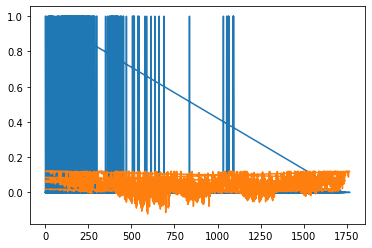

In [ ]:
plt.plot(df_y)
plt.plot(result.fittedvalues)

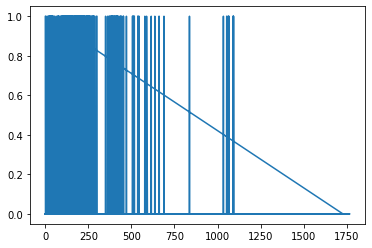

In [ ]:
plt.plot(df_y)


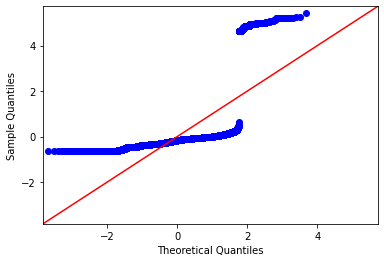

In [ ]:
sm.qqplot(result.resid, fit=True, line='45')
pass

In [ ]:
all_df.dtypes

No.         float64
区            object
発生日時         object
出没場所         object
状況           object
lat         float64
lng         float64
KEY_CODE      int64
年度            int64
年             int64
月             int64
日             int64
曜日           object
時間           object
人口            int64
平均気温        float64
天候（昼）_1      object
天候（昼）_2      object
天候（夜）_1      object
天候（夜）_2      object
geometry     object
dtype: object

In [ ]:
pd.merge(b, all_df, on="KEY_CODE", how="left")

,KEY_CODE,人口_x,geometry_x,lng_center,lat_center,No.,区,発生日時,出没場所,状況,lat,lng,年度,年,月,日,曜日,時間,人口_y,平均気温,天候（昼）_1,天候（昼）_2,天候（夜）_1,天候（夜）_2,geometry_y
0,644121923,2,"POLYGON ((141.15625 42.91250, 141.15000 42.912...",141.153125,42.914583,105.0,南区,8月9日(木)19:30,南区定山渓無番地（中山峠と定山渓トンネルの中間付近）,ヒグマを目撃,42.915709,141.153458,2018.0,2018.0,8.0,9.0,木,19:30,2.0,22.5,曇,曇,雨,雨,"POLYGON ((141.15625 42.91249999999999, 141.15 ..."
1,644122854,7,"POLYGON ((141.32500 42.90417, 141.31875 42.904...",141.321875,42.906250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,644122871,1,"POLYGON ((141.34375 42.90000, 141.33750 42.900...",141.340625,42.902083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,644122873,4,"POLYGON ((141.34375 42.90417, 141.33750 42.904...",141.340625,42.906250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,644122874,2,"POLYGON ((141.35000 42.90417, 141.34375 42.904...",141.346875,42.906250,39.0,南区,7月8日(土)11:00,南区滝野224番地付近,ヒグマを目撃,42.908105,141.344734,2017.0,2017.0,7.0,8.0,土,11:00,2.0,24.1,晴,晴,晴,曇,"POLYGON ((141.35 42.90416666666666, 141.34375 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,644163104,4,"POLYGON ((141.38750 43.17917, 141.38125 43.179...",141.384375,43.181250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1916,644163122,2,"POLYGON ((141.41250 43.17500, 141.40625 43.175...",141.409375,43.177083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1917,644163201,6,"POLYGON ((141.38125 43.18333, 141.37500 43.183...",141.378125,43.185417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1918,644163202,3,"POLYGON ((141.38750 43.18333, 141.38125 43.183...",141.384375,43.185417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.get_dummies(all_df, columns=["年度"], sparse=True)

,No.,区,発生日時,出没場所,状況,lat,lng,KEY_CODE,年,月,日,曜日,時間,人口,平均気温,天候（昼）_1,天候（昼）_2,天候（夜）_1,天候（夜）_2,geometry,年度_2016,年度_2017,年度_2018,年度_2019,年度_2020
0,1.0,南区,平28年 4月14日(木),南区南沢市民の森 案内板2番と3番の間,足跡を確認,42.984113,141.301965,644132841,2016,4,14,木,不明,67,11.0,曇,曇,雨,雨,"POLYGON ((141.30625 42.98333333333333, 141.3 4...",1,0,0,0,0
1,2.0,南区,平28年 4月20日(水),南区白川市民の森 案内板7番から8番へ30m地点 案内板5番から21番へ200m地点,足跡・爪痕を確認,42.983615,141.283236,644132822,2016,4,20,水,不明,0,9.7,晴,曇,曇,晴,"POLYGON ((141.2875 42.98333333333333, 141.2812...",1,0,0,0,0
2,3.0,南区,平28年 4月21日(木),南区定山渓920番地付近 豊羽鉱山への道道,足跡を確認,42.982008,141.041829,644130733,2016,4,21,木,不明,0,13.8,晴,曇,曇,曇,"POLYGON ((141.04375 42.97916666666666, 141.037...",1,0,0,0,0
3,4.0,南区,平28年 4月28日(木),南区真駒内柏丘1丁目 真駒内川河川敷,ヒグマらしき動物を目撃,42.984386,141.348751,644132872,2016,4,28,木,不明,1417,7.6,曇,曇,雨,雨,"POLYGON ((141.35 42.98333333333333, 141.34375 ...",1,0,0,0,0
4,5.0,南区,平28年 5月14日(土),南区定山渓（定山渓自然の村南東約300mの林道）,ヒグマを目撃,42.931382,141.152064,644131123,2016,5,14,土,不明,0,14.5,晴,晴,曇,曇,"POLYGON ((141.15625 42.92916666666667, 141.15 ...",1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,91.0,手稲区,令和2年11月12日(木),手稲区手稲本町593番地151付近（手稲山麓西線上）,足跡・鳴き声を確認,43.077052,141.200096,644141961,2020,11,12,木,不明,0,4.3,晴,晴,晴,曇,"POLYGON ((141.20625 43.075, 141.2 43.075, 141....",0,0,0,0,1
559,92.0,西区,令和2年12月4日(金),西区小別沢20番地付近,足跡、被毛を確認,43.047359,141.277738,644142523,2020,12,4,金,不明,6,0.8,晴,曇,曇,曇,"POLYGON ((141.28125 43.04583333333333, 141.275...",0,0,0,0,1
560,93.0,南区,令和2年12月23日(水)18:30,南区石山1045番地2付近,ヒグマを目撃,42.946191,141.328557,644132363,2020,12,23,水,18:30,41,1.3,晴,晴,曇,曇,"POLYGON ((141.33125 42.94583333333333, 141.325...",0,0,0,0,1
561,94.0,南区,令和3年3月25日(木),南区白川市民の森(案内板20番から17番方向へ約20mの付近),足跡を確認,42.983615,141.283236,644132822,2021,3,25,木,不明,0,9.5,曇,曇,雨,雨,"POLYGON ((141.2875 42.98333333333333, 141.2812...",0,0,0,0,1


In [ ]:
!pip install lmdiag

     |████████████████████████████████| 1.5 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 30.2 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
forest_df = pd.read_csv('/content/drive/MyDrive/forest_bears/sapporo_df.csv')

In [ ]:
forest_df

,KEY_CODE,dummy_1995,dummy_2000,dummy_2005,dummy_2010,dummy_2015,geometry,lng_center,lat_center
0,644120174,0.0,1.0,1.0,1.0,1.0,"POLYGON ((141.1 42.84583333333333, 141.09375 4...",141.096875,42.847917
1,644122981,0.0,0.0,0.0,0.0,0.0,"POLYGON ((141.35625 42.90833333333333, 141.35 ...",141.353125,42.910417
2,644130732,0.0,1.0,1.0,1.0,1.0,"POLYGON ((141.05 42.97499999999999, 141.04375 ...",141.046875,42.977083
3,644130733,0.0,0.0,0.0,1.0,1.0,"POLYGON ((141.04375 42.97916666666666, 141.037...",141.040625,42.981250
4,644130734,0.0,1.0,0.0,1.0,1.0,"POLYGON ((141.05 42.97916666666666, 141.04375 ...",141.046875,42.981250
...,...,...,...,...,...,...,...,...,...
1810,644152961,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.33125 43.15833333333333, 141.325...",141.328125,43.160417
1811,644153171,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.46875 43.09166666666666, 141.462...",141.465625,43.093750
1812,644153822,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.4125 43.15, 141.40625 43.15, 141...",141.409375,43.152083
1813,644153831,1.0,1.0,1.0,1.0,0.0,"POLYGON ((141.41875 43.15, 141.4125 43.15, 141...",141.415625,43.152083


In [ ]:
fin_df

,出没ダミー,人口,年度_2017,年度_2018,年度_2019,年度_2020,交差項_2017,交差項_2018,交差項_2019,交差項_2020
0,0,2,0,0,0,0,0,0,0,0
1,0,7,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,4,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1736,0,4,0,0,0,1,0,0,0,4
1737,0,2,0,0,0,1,0,0,0,2
1738,0,6,0,0,0,1,0,0,0,6
1739,0,3,0,0,0,1,0,0,0,3


In [ ]:
fin_df.columns

Index(['出没ダミー', '人口', '年度_2017', '年度_2018', '年度_2019', '年度_2020', '交差項_2017',
       '交差項_2018', '交差項_2019', '交差項_2020'],
      dtype='object')

In [ ]:
form_ols = '出没ダミー ~ 人口 + 年度_2017 + 年度_2018 + 年度_2019 + 年度_2020 + 交差項_2017 + 交差項_2018 + 交差項_2019 + 交差項_2020'

mod_ols = ols(form_ols, data=fin_df)
res_ols = mod_ols.fit()

print(res_ols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0175      0.007      2.611      0.009       0.004       0.031
人口         -6.897e-06   4.14e-06     -1.665      0.096    -1.5e-05    1.22e-06
年度_2017        0.0428      0.009      4.538      0.000       0.024       0.061
年度_2018        0.0670      0.009      7.123      0.000       0.049       0.085
年度_2019        0.1022      0.009     10.953      0.000       0.084       0.121
年度_2020        0.0500      0.009      5.320      0.000       0.032       0.068
交差項_2017   -1.687e-05   5.85e-06     -2.885      0.004   -2.83e-05   -5.41e-06
交差項_2018   -2.651e-05   5.85e-06     -4.535      0.000    -3.8e-05   -1.51e-05
交差項_2019   -3.667e-05   5.82e-06     -6.297      0.000   -4.81e-05   -2.53e-05
交差項_2020   -2.043e-05   5.84e-06     -3.499      0.000   -3.19e-05   -8.99e-06


In [ ]:
res_robust = res_ols.get_robustcov_results(cov_type='HC3', use_t=True)

print(res_robust.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0175      0.004      3.934      0.000       0.009       0.026
人口         -6.897e-06    1.9e-06     -3.622      0.000   -1.06e-05   -3.16e-06
年度_2017        0.0428      0.009      4.664      0.000       0.025       0.061
年度_2018        0.0670      0.010      6.523      0.000       0.047       0.087
年度_2019        0.1022      0.011      8.896      0.000       0.080       0.125
年度_2020        0.0500      0.009      5.265      0.000       0.031       0.069
交差項_2017   -1.687e-05   3.99e-06     -4.233      0.000   -2.47e-05   -9.06e-06
交差項_2018   -2.651e-05   4.38e-06     -6.050      0.000   -3.51e-05   -1.79e-05
交差項_2019   -3.667e-05      5e-06     -7.328      0.000   -4.65e-05   -2.69e-05
交差項_2020   -2.043e-05   4.07e-06     -5.015      0.000   -2.84e-05   -1.24e-05


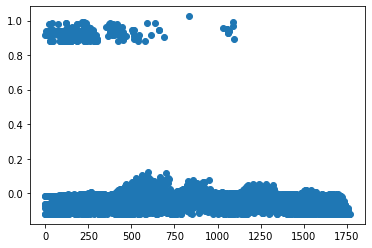

In [ ]:
res_ols.resid.plot(style='o')
pass